In [13]:
from __future__ import print_function
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import librosa
import seaborn as sb
import matplotlib.pyplot as plt
import itertools
import re
import random
import gc
from os import listdir
from os.path import isfile, join
from numpy import median, diff
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [14]:
# start with each input secion maps to one note
# train model for that (just list comprhension on noets for contains 1 maps to true)

# then move to bars eg section of 4 bars maps to output for each note
# error = probability of note being true vs was it really

# try bar + prev notes (home use weird dimensioned data?) to predict next notes

# try feeding in non structured data (bpm, position of time in song, song length, 
# things about feel of song (generated features))
# try using keras merge layer to add extra features

In [15]:
samples_back_included = 24
num_features = 42

def get_features_for_index(beat_features, notes, index):
    if index < 0:
        return [0] * num_features
    features = beat_features[index]
    misc_features = [index % 48, get_steps_for_index(notes, index - 1)]
    return np.concatenate((features, misc_features))

def get_steps_for_index(notes, index):
    if index < 0:
        return [True, False, False, False, False]
    row = notes[index][0]
    steps = row.count('1')
    mines = row.count('M')
    return [steps == 0, steps >= 1, steps >= 2, steps >= 3, mines > 0]

def build_batch_generator():
    songs_to_use = pd.read_csv('data/songs_to_use.csv').values
    save_files = listdir('data')
    for song_data in songs_to_use[:100]:
        if '{0}_beat_features.csv'.format(song_data[0]) in save_files and '{0}_notes.csv'.format(song_data[0]) in save_files:
            X = []
            y = []
            beat_features_rotated = pd.read_csv('data/{0}_beat_features.csv'.format(song_data[0])).values
            notes = pd.read_csv('data/{0}_notes.csv'.format(song_data[0]), converters={'0': lambda x: str(x)}).values
            beat_features = np.flipud(np.rot90(np.array(beat_features_rotated)))
            for i in range(min(len(notes), len(beat_features))):
                features = [feature for j in range(samples_back_included) for feature in get_features_for_index(beat_features, notes, i - j)]
                X.append(features)
                y.append(get_steps_for_index(notes, i))
            yield (np.array(X), np.array(y))

# Categories =
- no_notes
- one_note
- two_notes
- many_notes
- mine

In [48]:
num_classes = 5

beat_feature_model = Sequential()
beat_feature_model.add(Dense(64, input_dim=samples_back_included * num_features, init='uniform', activation='relu'))
beat_feature_model.add(Dense(64, activation='relu'))
beat_feature_model.add(Dense(num_classes, activation='sigmoid'))

beat_feature_model.compile(loss='mse',
                           optimizer='adadelta',
                           metrics=['accuracy'])

In [49]:
gen = build_batch_generator()
#for data in gen:
for i in range(5):
    X, y = next(gen)
    beat_feature_model.train_on_batch(X, y)

gen = build_batch_generator()
for i in range(2):
    X, y = next(gen)
    print (beat_feature_model.test_on_batch(X, y))

INFO (theano.gof.compilelock): Refreshing lock /Users/jgzuke/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


[array(1.0, dtype=float32), array(0.16746795177459717, dtype=float32)]
[array(1.0, dtype=float32), array(0.1041666641831398, dtype=float32)]


In [50]:
X, y = next(gen)
predictions = beat_feature_model.predict(X)

Length: 4080


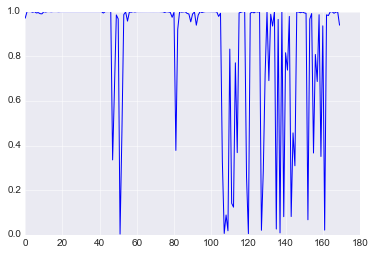

In [51]:
print ('Length: ' + str(len(predictions)))
test = [predictions[i] for i in range(len(predictions)) if i % 24 == 0]
sb.set_style("darkgrid")
plt.plot(test)
plt.show()

In [47]:
test

[array([ 0.99999952], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 array([ 1.], dtype=float32),
 a

In [165]:
test = pd.read_csv('data/In The Groove~Anubis_beat_features.csv').values

In [168]:
len(test[0])

2587

In [112]:
beat_feature_model.fit(X[:1000], y[:1000], nb_epoch=10, batch_size=32)

Epoch 1/10
1000/1000 [==============================] - 0s - loss: 0.3267 - acc: 0.9160     
Epoch 2/10
1000/1000 [==============================] - 0s - loss: 0.3035 - acc: 0.9160     
Epoch 3/10
1000/1000 [==============================] - 0s - loss: 0.2968 - acc: 0.9160     
Epoch 4/10
1000/1000 [==============================] - 0s - loss: 0.2947 - acc: 0.9160     
Epoch 5/10
1000/1000 [==============================] - 0s - loss: 0.3047 - acc: 0.9160     
Epoch 6/10
1000/1000 [==============================] - 0s - loss: 0.2985 - acc: 0.9160     
Epoch 7/10
1000/1000 [==============================] - 0s - loss: 0.3028 - acc: 0.9160     
Epoch 8/10
1000/1000 [==============================] - 0s - loss: 0.2981 - acc: 0.9160     
Epoch 9/10
1000/1000 [==============================] - 0s - loss: 0.2936 - acc: 0.9160     
Epoch 10/10
1000/1000 [==============================] - 0s - loss: 0.2879 - acc: 0.9160     


In [ ]:
beat_feature_model = Sequential([
    Dense(32, input_dim=784),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

misc_feature_model = Sequential([
    Dense(32, input_dim=4),
    Activation('relu'),
])

model = Sequential([
    Merge([beat_feature_model, misc_feature_model], mode='concat'),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def false_rates(y_true, y_pred):
    false_neg = ...
    false_pos = ...
    return {
        'false_neg': false_neg,
        'false_pos': false_pos,
    }

model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy', mean_pred, false_rates])

model.fit(data, labels, nb_epoch=10, batch_size=32)
model.predict(self, x, batch_size=32, verbose=0)